In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [2]:
def test_features(df, features, target):
    """
    Test multiple features for linear regression models, visualize the regression for each feature
    with both training and testing data.
    
    Parameters:
    - df: DataFrame containing the dataset.
    - features: List of feature names to test.
    - target: Name of the target variable.
    
    Returns:
    - A DataFrame with the results of the analysis for each feature.
    """
    # Initialize an empty list to store results
    results = []
    
    for feature in features:
        # Prepare the data
        X = df[[feature]]  # Feature matrix
        y = df[target]  # Target variable
        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
        
        # Create and train the linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Predict target values for both training and testing set
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calculate evaluation metrics using test set
        mae = round(mean_absolute_error(y_test, y_pred_test), 2)
        mse = round(mean_squared_error(y_test, y_pred_test), 2)
        rmse = round(mean_squared_error(y_test, y_pred_test, squared=False), 2)
        R2 = round(r2_score(y_test, y_pred_test), 2)
        
        # Append the results
        results.append({
            'Feature': feature,
            'Coefficient': round(model.coef_[0], 3),
            'Intercept': round(model.intercept_, 2),
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': R2
        })
        
        # Visualization
        plt.figure(figsize=(10, 6))
        plt.scatter(X_train, y_train, color='blue', alpha=0.5, label='Training data')
        plt.scatter(X_test, y_test, color='gray', alpha=0.5, label='Testing data')
        plt.plot(X_train, y_pred_train, 'r-', linewidth=1, label='Model')
        plt.title(f'Linear Regression: {target} vs {feature}')
        plt.xlabel(feature)
        plt.ylabel(target)
        plt.legend()
        plt.show()
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    display(results_df)
    return results_df

In [3]:
df = pd.read_csv('CropPol_field_level_data.csv')

In [4]:
column_names = ['study_id', 'site_id', 'crop', 'yield', 'yield_units', 'observed_pollinator_richness', 'country', 'abundance',
       'ab_honeybee', 'ab_bombus', 'ab_wildbees', 'ab_syrphids',
       'ab_humbleflies', 'ab_other_flies', 'ab_beetles', 'ab_lepidoptera',
       'ab_nonbee_hymenoptera', 'ab_others', 
       'visitation_rate', 'visit_honeybee', 'visit_bombus', 'visit_wildbees',
       'visit_syrphids', 'visit_humbleflies', 'visit_other_flies',
       'visit_beetles', 'visit_lepidoptera', 'visit_nonbee_hymenoptera',
       'visit_others']
df_normal = df[column_names]

In [5]:
df_normal = df_normal.dropna(subset=['yield', 'abundance'])
df_normal.shape

(1616, 29)

In [6]:
def normalize_group(df_group):
    scaler = StandardScaler()
    columns = ['yield', 'observed_pollinator_richness', 'abundance',
               'ab_honeybee', 'ab_bombus', 'ab_wildbees', 'ab_syrphids',
               'ab_humbleflies', 'ab_other_flies', 'ab_beetles', 'ab_lepidoptera',
               'ab_nonbee_hymenoptera', 'ab_others', 
               'visitation_rate', 'visit_honeybee', 'visit_bombus', 'visit_wildbees',
               'visit_syrphids', 'visit_humbleflies', 'visit_other_flies',
               'visit_beetles', 'visit_lepidoptera', 'visit_nonbee_hymenoptera',
               'visit_others']
    df_group[columns] = scaler.fit_transform(df_group[columns])
    return df_group


In [7]:
# Group by 'study_id' and apply the normalization function
df_normalized = df_normal.groupby('study_id').apply(normalize_group)

c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\utils\extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\utils\extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\utils\extmath.py:1076: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\utils\extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\utils\extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\utils\extmath

In [8]:
df_normalized.isna().sum()

study_id                          0
site_id                           0
crop                              0
yield                             0
yield_units                      44
observed_pollinator_richness    477
country                           0
abundance                         0
ab_honeybee                      25
ab_bombus                        36
ab_wildbees                      63
ab_syrphids                     114
ab_humbleflies                  123
ab_other_flies                  123
ab_beetles                      128
ab_lepidoptera                  123
ab_nonbee_hymenoptera           128
ab_others                       128
visitation_rate                 771
visit_honeybee                  777
visit_bombus                    786
visit_wildbees                  816
visit_syrphids                  842
visit_humbleflies               886
visit_other_flies               873
visit_beetles                   886
visit_lepidoptera               886
visit_nonbee_hymenoptera    

In [9]:
columns_to_fill = ['observed_pollinator_richness',
                   'ab_honeybee', 'ab_bombus', 'ab_wildbees', 'ab_syrphids',
                   'ab_humbleflies', 'ab_other_flies', 'ab_beetles', 'ab_lepidoptera',
                   'ab_nonbee_hymenoptera', 'ab_others', 
                   'visitation_rate', 'visit_honeybee', 'visit_bombus', 'visit_wildbees',
                   'visit_syrphids', 'visit_humbleflies', 'visit_other_flies',
                   'visit_beetles', 'visit_lepidoptera', 'visit_nonbee_hymenoptera',
                   'visit_others']

df_filled = df_normalized.copy()  # Make a copy if you want to keep df_normalized unchanged

df_filled[columns_to_fill] = df_filled[columns_to_fill].fillna(0)



All crops correlation with yield

In [10]:
# Select only the numerical columns for correlation
numerical_df_filled = df_filled.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr = numerical_df_filled.corr()

# Extract the correlations of 'fruit_set' with other columns
filled_yield_corr = corr['yield']

# Display the correlations
print('Fruit Set / Yield')
print(filled_yield_corr)

Fruit Set / Yield
yield                           1.000000
observed_pollinator_richness    0.094110
abundance                       0.153263
ab_honeybee                     0.089651
ab_bombus                       0.031744
ab_wildbees                     0.115714
ab_syrphids                     0.092004
ab_humbleflies                  0.030399
ab_other_flies                  0.077431
ab_beetles                     -0.028065
ab_lepidoptera                  0.026380
ab_nonbee_hymenoptera           0.033607
ab_others                      -0.011884
visitation_rate                 0.082037
visit_honeybee                  0.092190
visit_bombus                    0.013428
visit_wildbees                  0.044617
visit_syrphids                  0.008036
visit_humbleflies               0.018858
visit_other_flies               0.036474
visit_beetles                  -0.026806
visit_lepidoptera               0.013759
visit_nonbee_hymenoptera       -0.019044
visit_others                   -0.02424

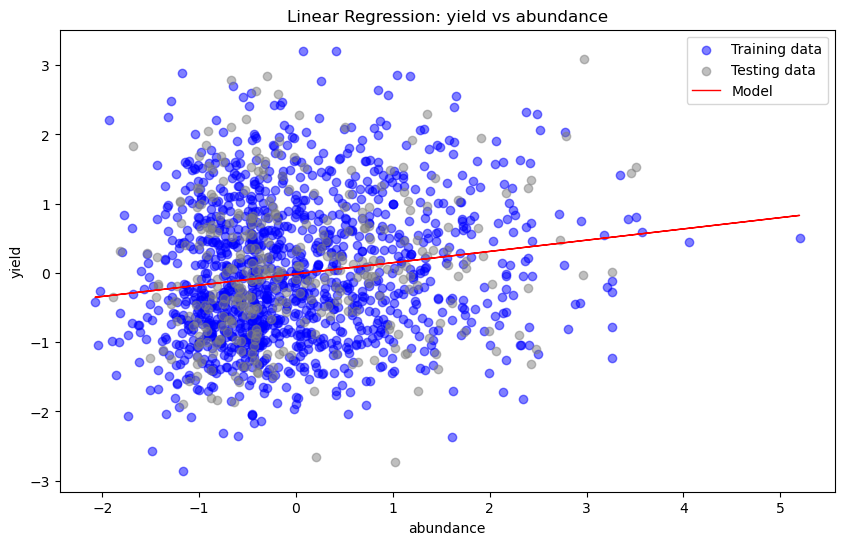

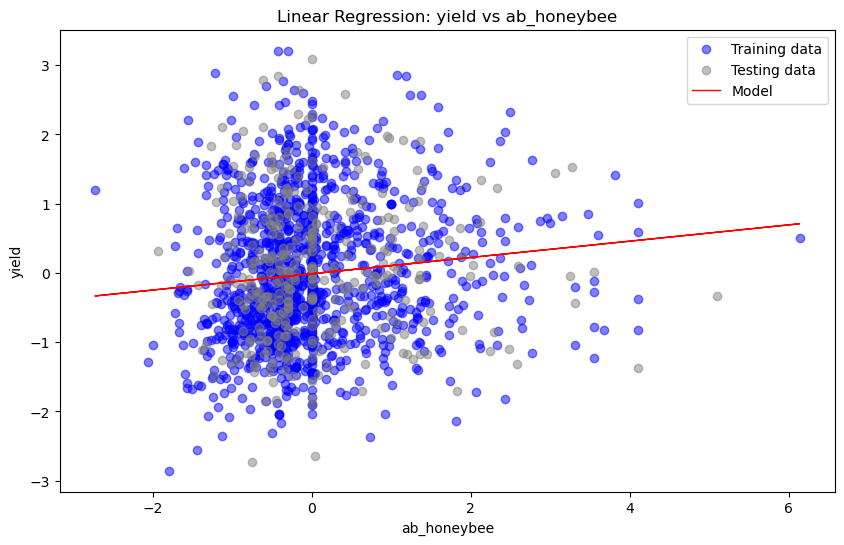

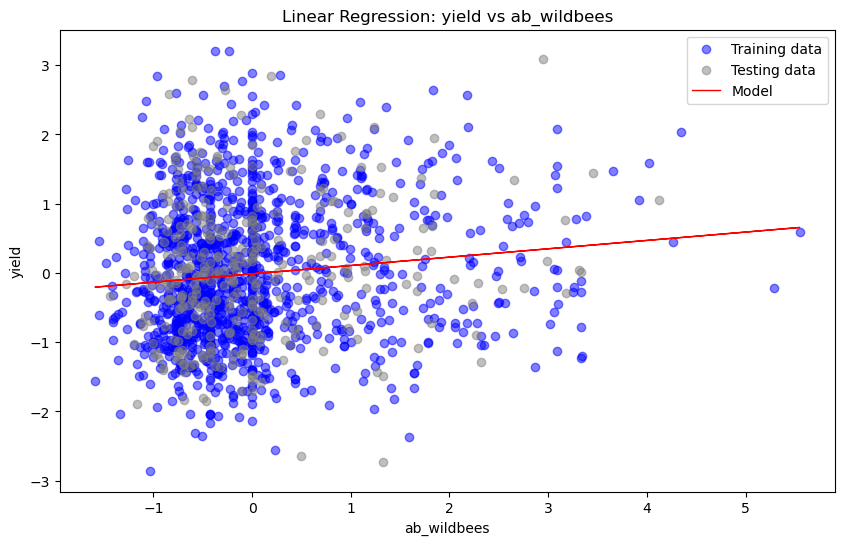

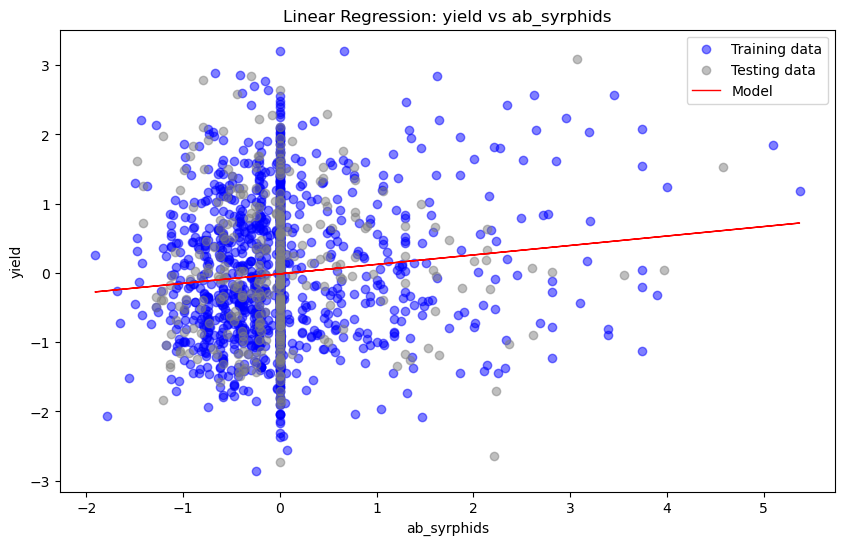

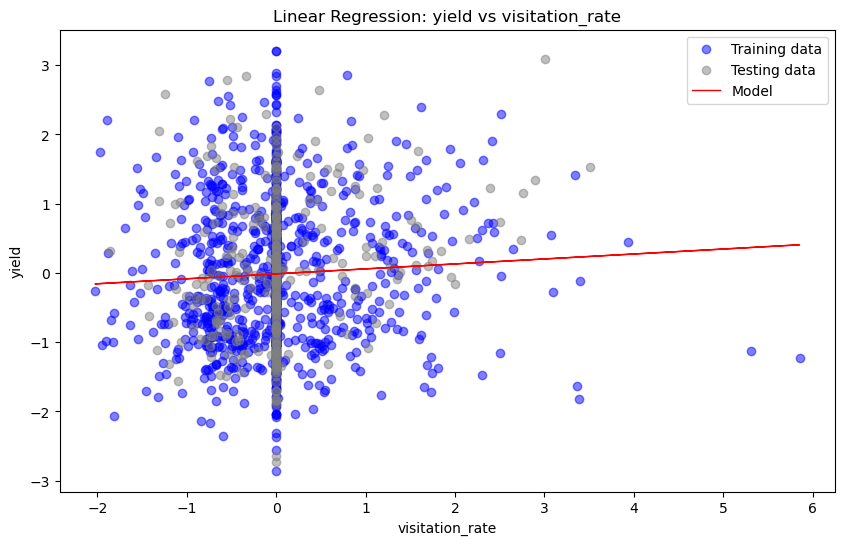

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.163,-0.01,0.79,1.01,1.00,0.01
1,ab_honeybee,0.118,-0.01,0.80,1.03,1.01,-0.02
2,ab_wildbees,0.121,-0.02,0.79,1.01,1.00,0.01
3,ab_syrphids,0.137,-0.02,0.80,1.03,1.01,-0.01
4,visitation_rate,0.072,-0.01,0.79,1.00,1.00,0.01


,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.163,-0.01,0.79,1.01,1.00,0.01
1,ab_honeybee,0.118,-0.01,0.80,1.03,1.01,-0.02
2,ab_wildbees,0.121,-0.02,0.79,1.01,1.00,0.01
3,ab_syrphids,0.137,-0.02,0.80,1.03,1.01,-0.01
4,visitation_rate,0.072,-0.01,0.79,1.00,1.00,0.01


In [11]:
features_to_test = ['abundance', 'ab_honeybee', 'ab_wildbees', 'ab_syrphids', 'visitation_rate']
target_column = 'yield'
results_df = test_features(df_filled, features_to_test, target_column)

display(results_df)

Drop crops with fewer than 20 rows

In [12]:
# Filter groups in 'df_filled' to keep only those with 20 or more rows
df_most_crops = df_filled.groupby('crop').filter(lambda x: len(x) >= 20)

# Display the shape of the original and filtered DataFrames as a quick check
print(f"Original shape: {df_filled.shape}")
print(f"Filtered shape: {df_most_crops.shape}")


Original shape: (1616, 29)
Filtered shape: (1453, 29)


Running on each crop separately

Actinidia deliciosa


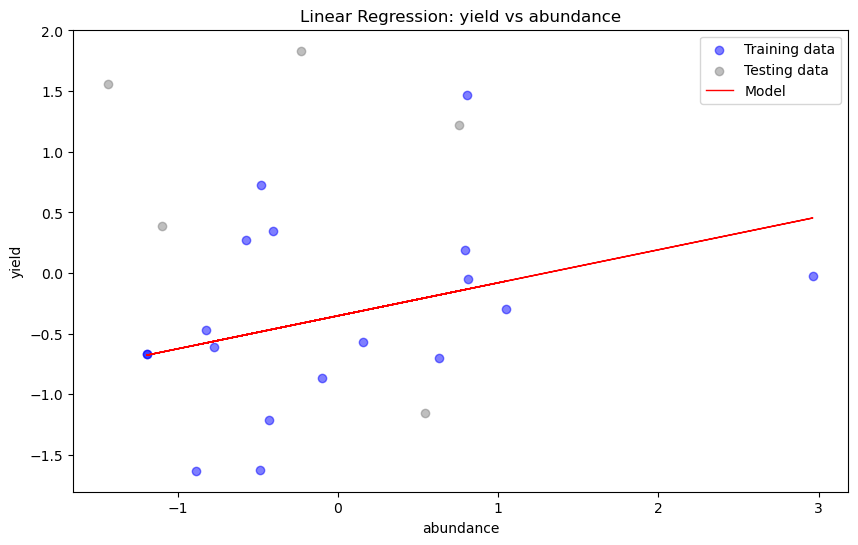

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.272,-0.35,1.58,2.84,1.68,-1.45


Allium porrum


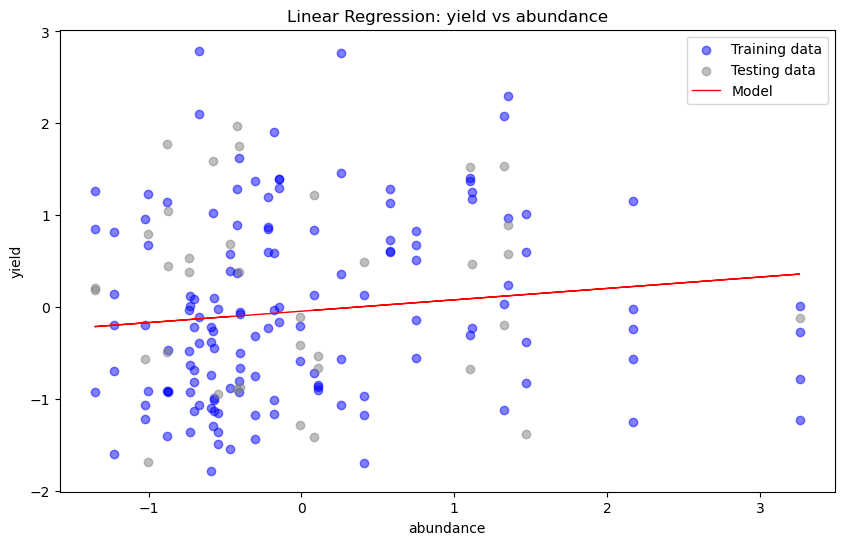

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.124,-0.04,0.88,1.05,1.02,-0.07


Brassica napus


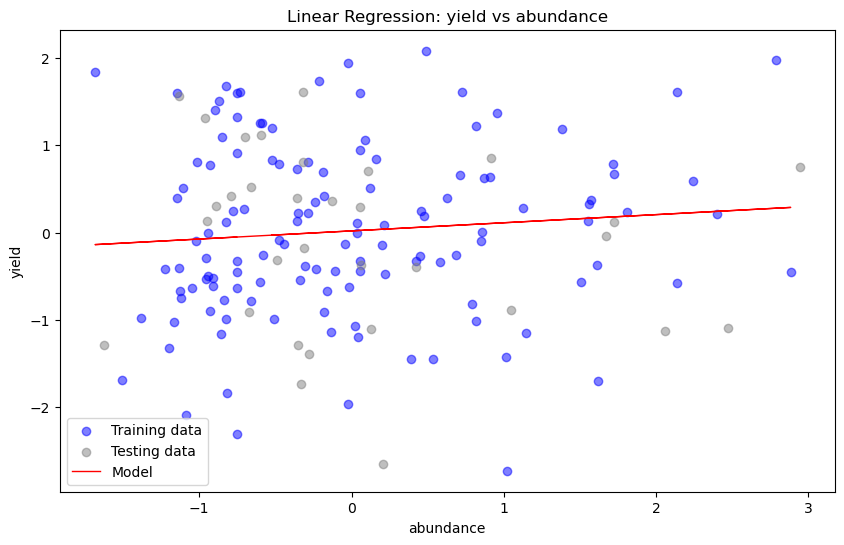

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.093,0.02,0.87,1.1,1.05,-0.05


Coffea arabica


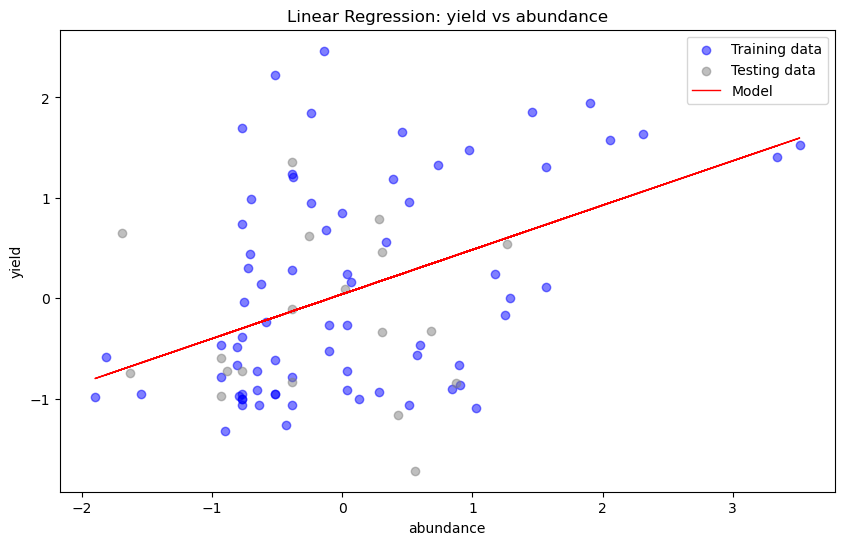

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.442,0.04,0.67,0.77,0.88,-0.26


Coffea canephora


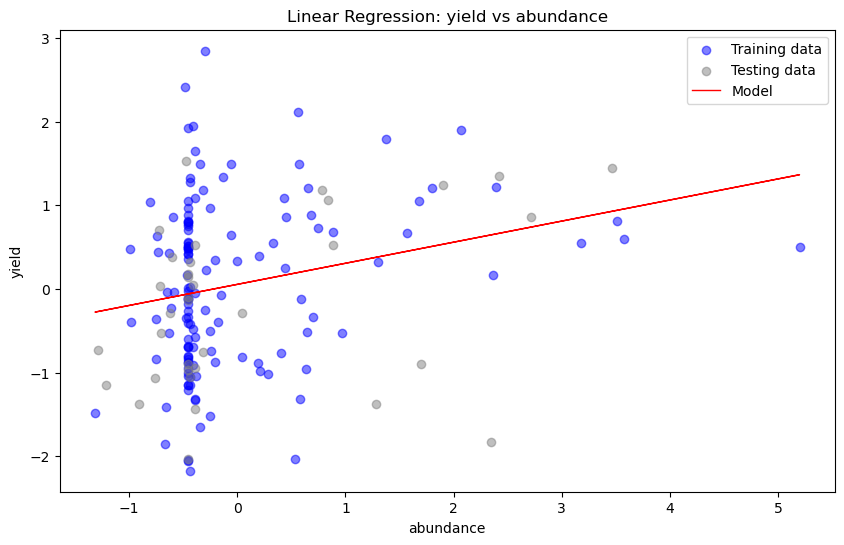

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.252,0.05,0.75,0.89,0.95,0.06


Cucurbita pepo


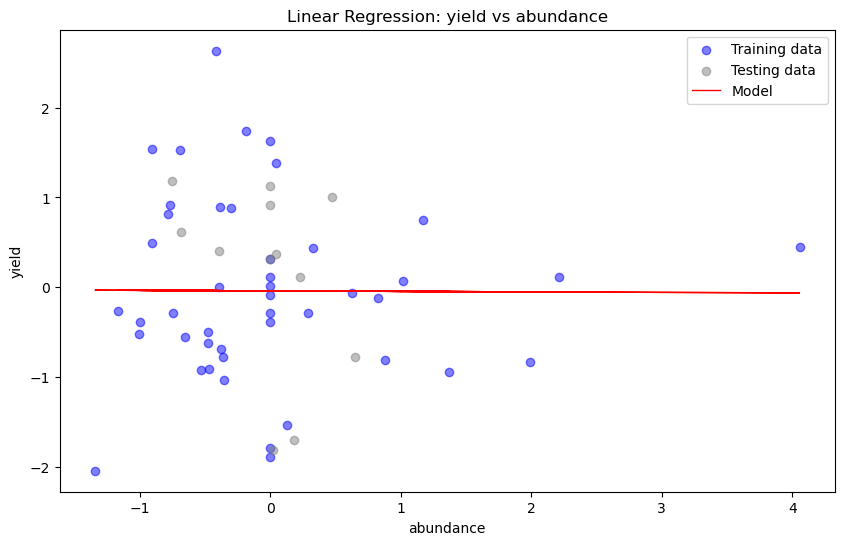

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,-0.006,-0.04,0.88,1.02,1.01,-0.03


Fagopyrum esculentum


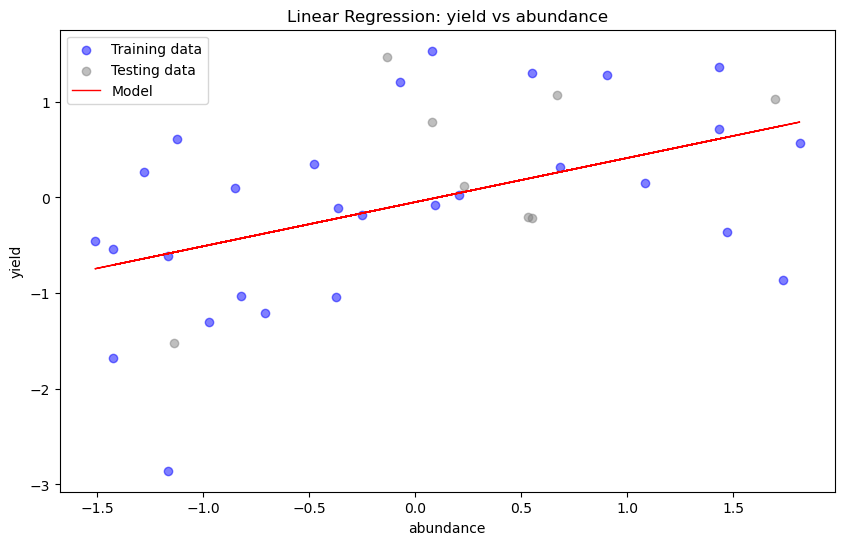

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.462,-0.05,0.66,0.64,0.8,0.22


Fragaria x ananassa


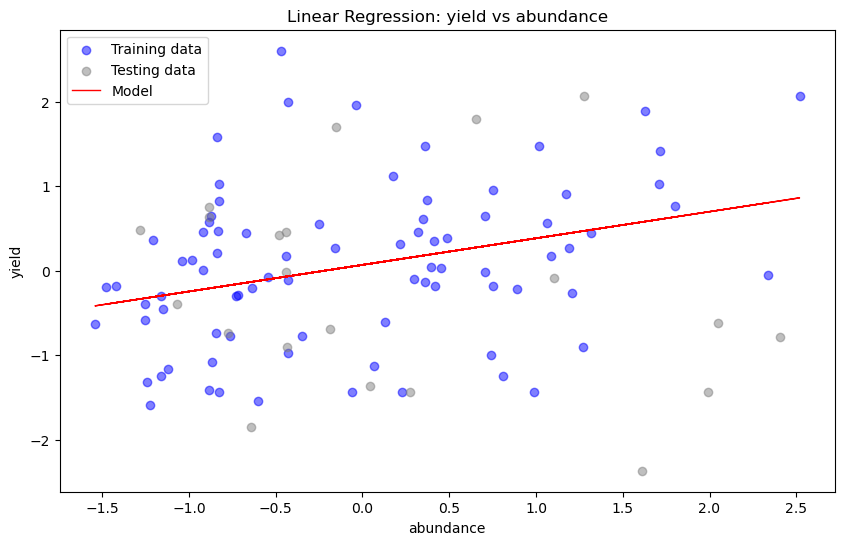

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.315,0.07,1.14,1.79,1.34,-0.29


Helianthus annuus


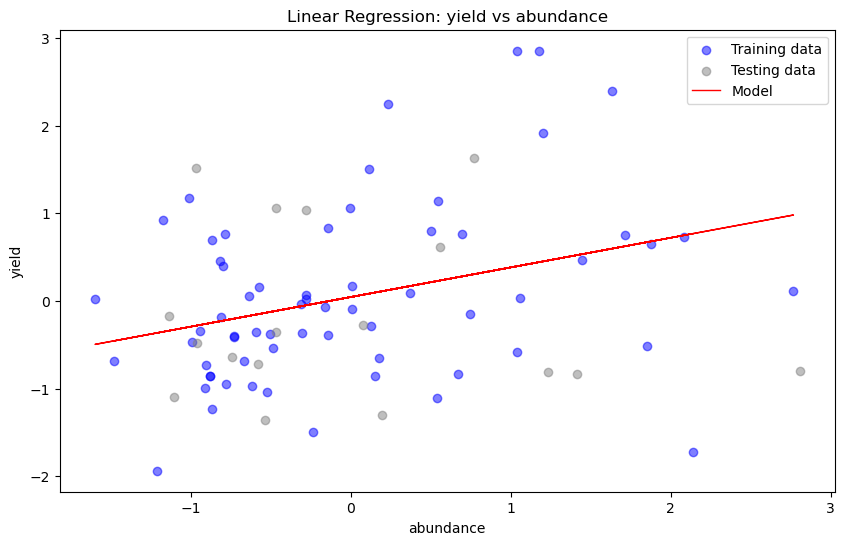

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.338,0.05,0.91,1.13,1.06,-0.27


Malus domestica


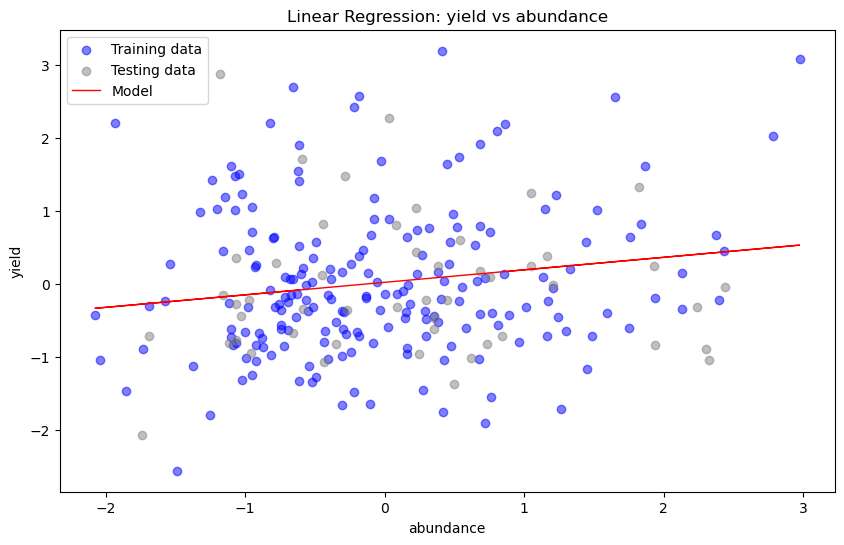

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.172,0.02,0.73,0.92,0.96,-0.05


Mangifera indica


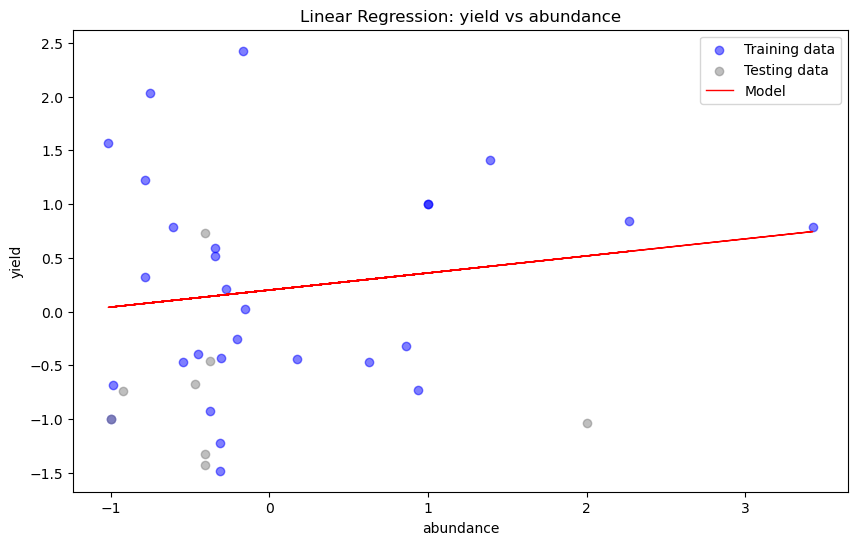

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.159,0.2,1.05,1.26,1.12,-2.14


Persea americana


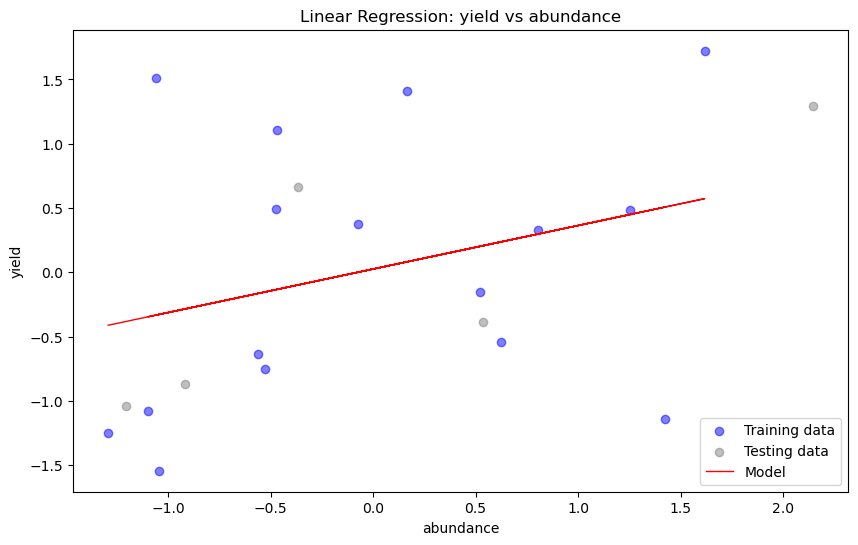

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.338,0.03,0.63,0.4,0.63,0.51


Phaseolus vulgaris L.


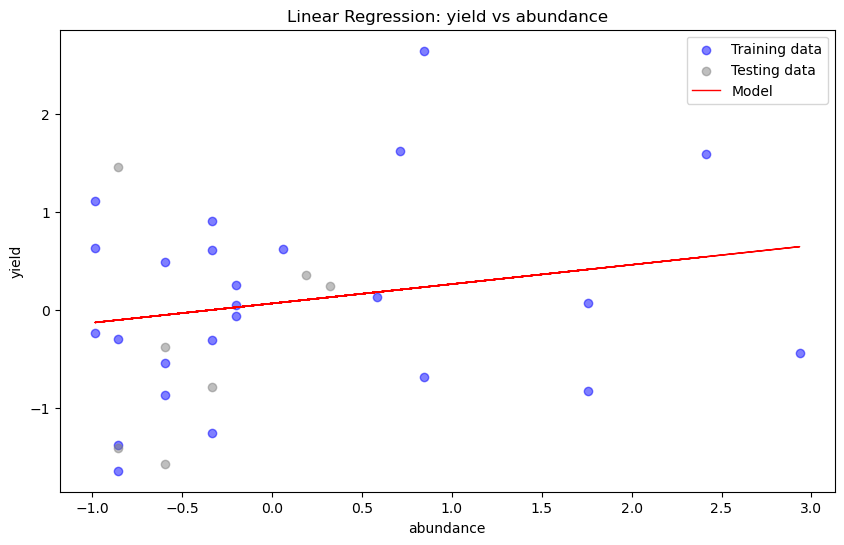

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.197,0.06,0.84,1.04,1.02,-0.05


Prunus avium


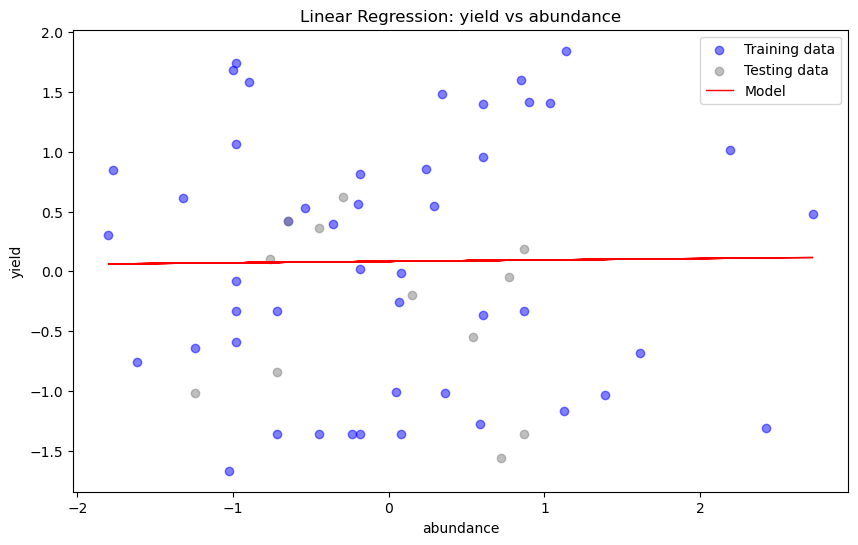

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.012,0.08,0.62,0.66,0.81,-0.34


Trifolium pratense


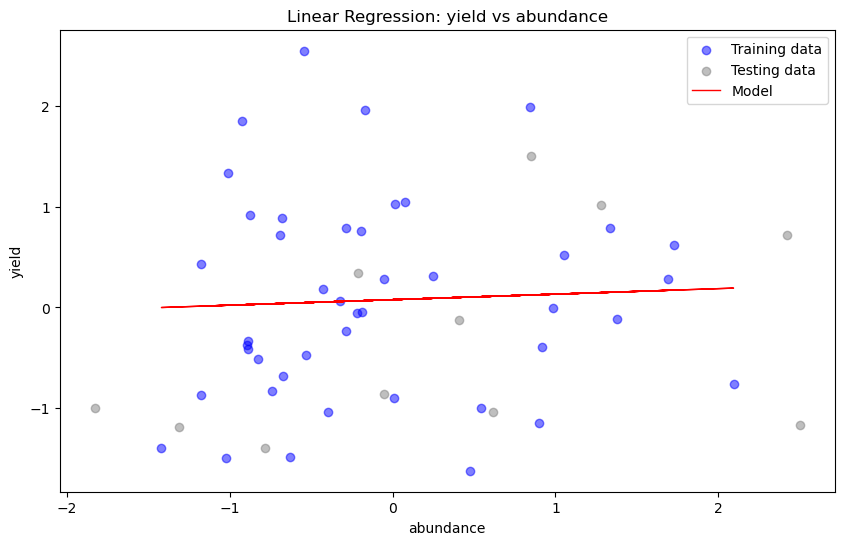

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.055,0.08,0.94,1.05,1.02,-0.09


Vaccinium corymbosum


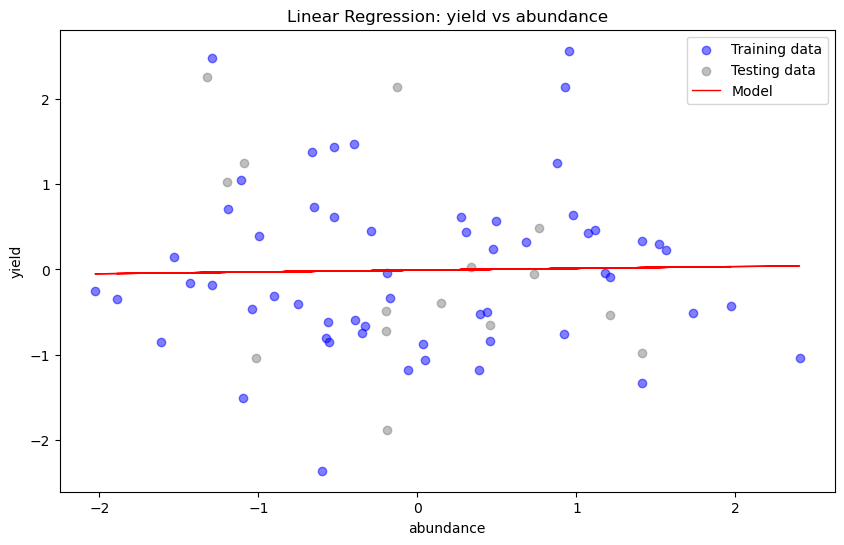

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.021,-0.01,0.93,1.33,1.15,-0.01


Vicia faba


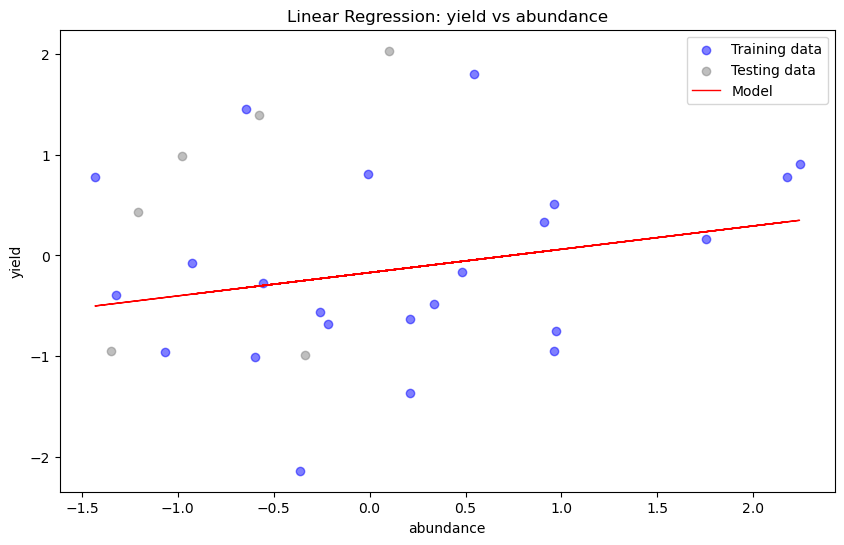

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.231,-0.17,1.22,1.84,1.36,-0.44


,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2,crop
0,abundance,0.272,-0.35,1.58,2.84,1.68,-1.45,Actinidia deliciosa
1,abundance,0.124,-0.04,0.88,1.05,1.02,-0.07,Allium porrum
2,abundance,0.093,0.02,0.87,1.10,1.05,-0.05,Brassica napus
3,abundance,0.442,0.04,0.67,0.77,0.88,-0.26,Coffea arabica
4,abundance,0.252,0.05,0.75,0.89,0.95,0.06,Coffea canephora
5,abundance,-0.006,-0.04,0.88,1.02,1.01,-0.03,Cucurbita pepo
6,abundance,0.462,-0.05,0.66,0.64,0.80,0.22,Fagopyrum esculentum
7,abundance,0.315,0.07,1.14,1.79,1.34,-0.29,Fragaria x ananassa
8,abundance,0.338,0.05,0.91,1.13,1.06,-0.27,Helianthus annuus
9,abundance,0.172,0.02,0.73,0.92,0.96,-0.05,Malus domestica


In [13]:
def run_test_features_by_crop(df, features_to_test, target_column):
    grouped_results = []  # To store results of each group
    
    for crop_name, group_df in df.groupby('crop'):
        print(crop_name)
        # Run test_features() for the current group
        result = test_features(group_df, features_to_test, target_column)
        
        # Add a column to the result to identify the crop
        result['crop'] = crop_name
        
        # Append the result of this group to the list
        grouped_results.append(result)
    
    # Concatenate all results into a single DataFrame
    final_results_df = pd.concat(grouped_results, ignore_index=True)
    
    return final_results_df

# Usage
features_to_test = ['abundance']
target_column = 'yield'
results_df = run_test_features_by_crop(df_most_crops, features_to_test, target_column)

# Display the final results
display(results_df)


In [14]:
df_every = pd.read_csv('CropPol_field_level_data.csv')

In [15]:
df_every.shape
df_every['crop'].value_counts()

crop
Vaccinium corymbosum       586
Malus domestica            375
Citrullus lanatus          284
Brassica napus             254
Coffea canephora           193
Allium porrum              187
Coffea arabica             133
Helianthus annuus          126
Fragaria x ananassa        113
Prunus dulcis              108
Cucurbita pepo             106
Prunus avium               104
Malus pumila                89
Prunus cerasus              74
Trifolium pratense          63
Mangifera indica            60
Vicia faba                  60
Vaccinium macrocarpon       49
Solanum lycopersicum        39
Fagopyrum esculentum        38
Phaseolus vulgaris L.       35
Actinidia deliciosa         29
Persea americana            21
Anacardium occidentale      20
Capsicum annuum             18
Rubus idaeus                17
Passiflora edulis           16
Pyrus communis              14
Gossypium hirsutum          14
Cucumis melo                13
Cajanus cajan               12
Citrus paradisi             12
Cit

In [16]:
df_most_crops['crop'].value_counts()

crop
Malus domestica          248
Allium porrum            177
Coffea canephora         172
Brassica napus           160
Fragaria x ananassa      103
Coffea arabica            92
Helianthus annuus         81
Vaccinium corymbosum      72
Prunus avium              59
Cucurbita pepo            57
Trifolium pratense        55
Mangifera indica          36
Fagopyrum esculentum      36
Phaseolus vulgaris L.     32
Vicia faba                29
Actinidia deliciosa       23
Persea americana          21
Name: count, dtype: int64

In [17]:
print(df_every.shape)
print(df_filled.shape)
print(df_most_crops.shape)

(3394, 65)
(1616, 29)
(1453, 29)


In [18]:
df_most_crops['crop'].value_counts()

crop
Malus domestica          248
Allium porrum            177
Coffea canephora         172
Brassica napus           160
Fragaria x ananassa      103
Coffea arabica            92
Helianthus annuus         81
Vaccinium corymbosum      72
Prunus avium              59
Cucurbita pepo            57
Trifolium pratense        55
Mangifera indica          36
Fagopyrum esculentum      36
Phaseolus vulgaris L.     32
Vicia faba                29
Actinidia deliciosa       23
Persea americana          21
Name: count, dtype: int64

In [19]:
almCrop = ['Prunus dulcis']
df_alm = df_every[df_every['crop'].isin(almCrop)]
df_alm.shape

(108, 65)

In [20]:
df_alm.drop(['crop', 'variety', 'management', 'country',
       'latitude', 'longitude', 'X_UTM', 'Y_UTM', 'zone_UTM',
       'sampling_start_month', 'sampling_end_month', 'sampling_year',
       'field_size', 'yield2', 'yield2_units',
       'yield_treatments_no_pollinators', 'yield_treatments_pollen_supplement',
       'yield_treatments_no_pollinators2',
       'yield_treatments_pollen_supplement2', 'fruits_per_plant',
       'fruit_weight', 'plant_density', 'seeds_per_fruit', 'seeds_per_plant',
       'seed_weight', 'sampling_richness', 'observed_pollinator_richness',
       'other_pollinator_richness', 'other_richness_estimator_method',
       'richness_restriction', 'sampling_abundance', 'abundance',
       'ab_honeybee', 'ab_bombus', 'ab_wildbees', 'ab_syrphids',
       'ab_humbleflies', 'ab_other_flies', 'ab_beetles', 'ab_lepidoptera',
       'ab_nonbee_hymenoptera', 'ab_others', 'total_sampled_area',
       'total_sampled_time', 'sampling_visitation', 'Publication', 'Credit', 'Email_contact', 'notes'], axis=1, inplace=True)
df_alm.shape

C:\Users\psabi\AppData\Local\Temp\ipykernel_13008\3350297391.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alm.drop(['crop', 'variety', 'management', 'country',


(108, 16)

In [21]:
df_alm.to_csv('alm.csv')

In [22]:
df_almo = pd.read_csv('alm.csv')
df_almo.shape

(108, 17)

Normalizing almo df

In [23]:
def normalize_group(df_group):
    scaler = StandardScaler()
    columns = ['yield', 
               'visitation_rate', 'visit_honeybee', 'visit_bombus', 'visit_wildbees',
               'visit_syrphids', 'visit_humbleflies', 'visit_other_flies',
               'visit_beetles', 'visit_lepidoptera', 'visit_nonbee_hymenoptera',
               'visit_others']
    df_group[columns] = scaler.fit_transform(df_group[columns])
    return df_group

In [24]:
# Group by 'study_id' and apply the normalization function
df_almo_norm = df_almo.groupby('study_id').apply(normalize_group)

c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\utils\extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\utils\extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\utils\extmath.py:1076: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\utils\extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\utils\extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\utils\extmath

Almond results 92 rows

In [25]:
features_to_test = ['visitation_rate', 'visit_honeybee', 'visit_bombus', 'visit_wildbees', 'visit_syrphids']
target_column = 'yield'
results_df = test_features(df_almo_norm, features_to_test, target_column)

display(results_df)

ValueError: Input y contains NaN.

In [27]:
appleCrop = ['Malus domestica']
df_apples = df_filled[df_filled['crop'].isin(appleCrop)]
df_apples.shape

(248, 29)

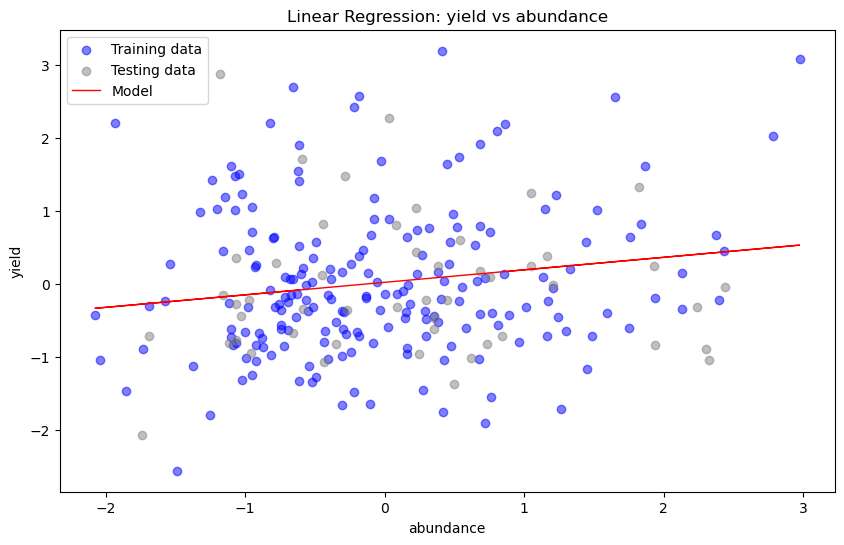

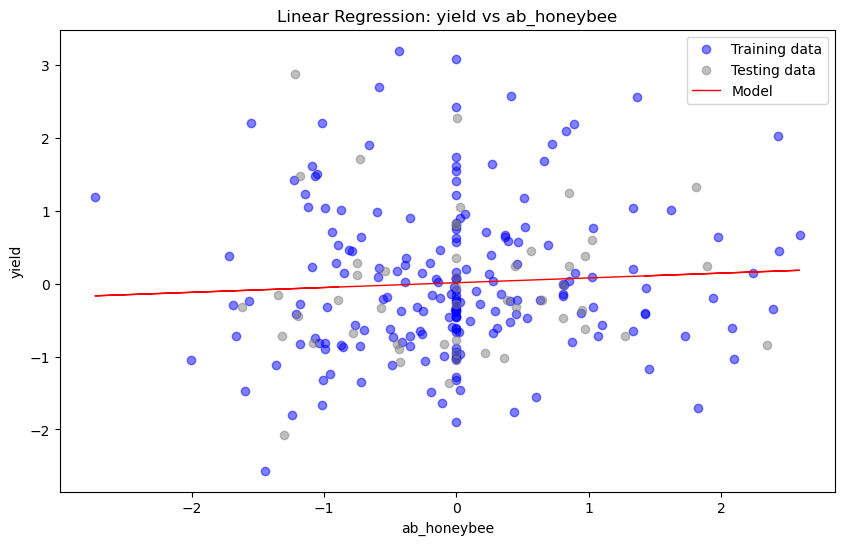

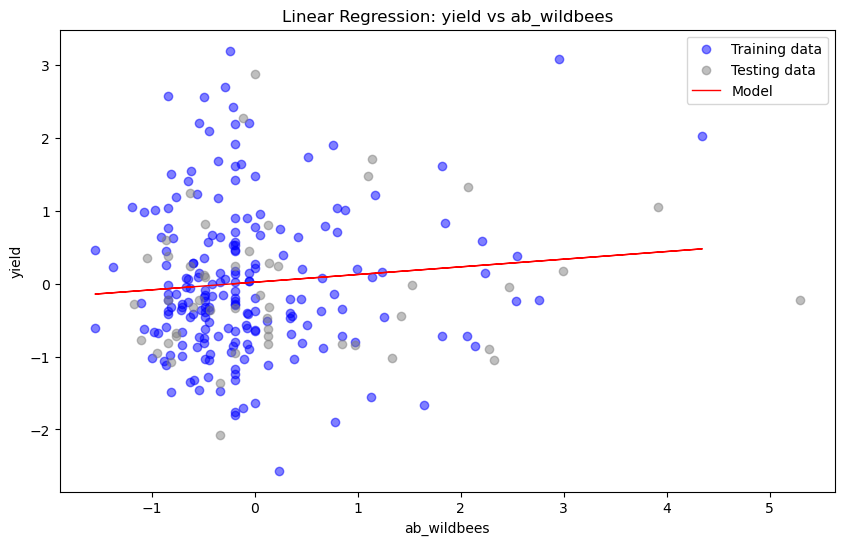

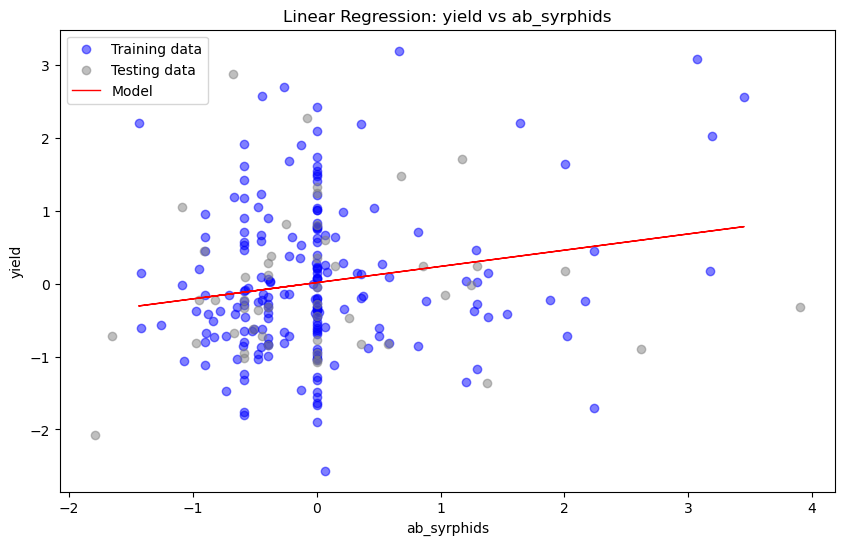

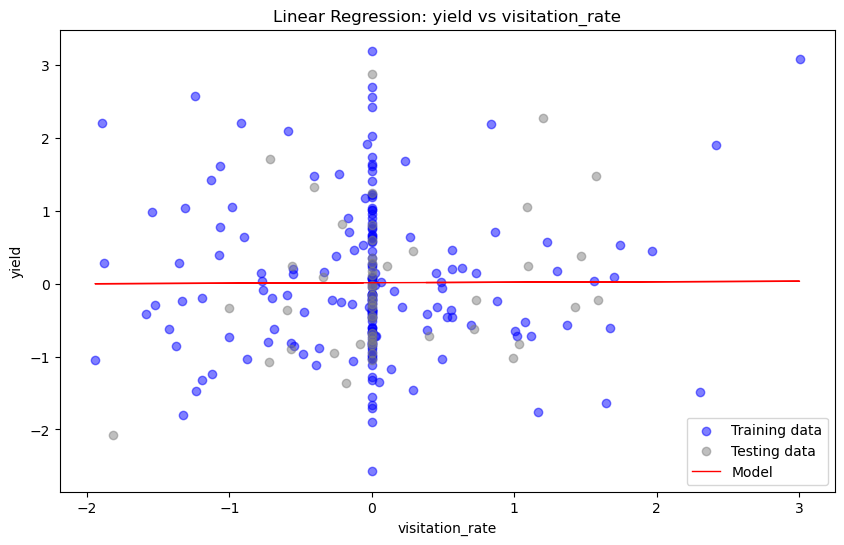

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.172,0.02,0.73,0.92,0.96,-0.05
1,ab_honeybee,0.066,0.01,0.72,0.88,0.94,-0.00
2,ab_wildbees,0.105,0.02,0.75,0.88,0.94,-0.01
3,ab_syrphids,0.223,0.02,0.74,0.91,0.95,-0.04
4,visitation_rate,0.007,0.01,0.73,0.88,0.94,-0.00


,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,abundance,0.172,0.02,0.73,0.92,0.96,-0.05
1,ab_honeybee,0.066,0.01,0.72,0.88,0.94,-0.00
2,ab_wildbees,0.105,0.02,0.75,0.88,0.94,-0.01
3,ab_syrphids,0.223,0.02,0.74,0.91,0.95,-0.04
4,visitation_rate,0.007,0.01,0.73,0.88,0.94,-0.00


In [28]:
features_to_test = ['abundance', 'ab_honeybee', 'ab_wildbees', 'ab_syrphids', 'visitation_rate']
target_column = 'yield'
results_df = test_features(df_apples, features_to_test, target_column)

display(results_df)